In [65]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier


In [34]:
df = pd.read_json('~/data-science/flatiron-school/capstone/avalanche-predictor/json_archive/model_5_df.json')
df['Date/Time (PST)'] = pd.to_datetime(df['Date/Time (PST)'])

In [35]:
df.head()

,Date/Time (PST),Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),date,24 Hour Snow (in),Total Snow Depth (in),...,month,max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow
0,2015-12-04 00:00:00,12.76,30.29,0.022,3.943,21.500,259.8,2015-12-04,2.499,25.66,...,12,30.29,20.94,32.02,13.81,21.50,21.50,46.490,46.49,46.49
1,2015-12-04 01:00:00,13.51,29.98,0.000,3.109,10.390,278.7,2015-12-04,2.701,23.25,...,12,30.29,21.20,32.02,15.03,21.50,21.50,46.490,46.49,46.49
10,2015-12-04 10:00:00,12.74,29.41,0.000,2.261,7.299,261.7,2015-12-04,1.083,26.44,...,12,30.29,23.39,30.29,17.25,21.50,21.50,2.701,46.49,46.49
100,2015-12-06 04:00:00,12.81,25.22,1.162,2.183,3.178,94.4,2015-12-06,0.401,35.68,...,12,25.22,23.93,25.22,23.93,7.19,7.19,10.610,10.61,10.61
1000,2016-01-05 16:00:00,12.77,24.26,1.447,2.001,2.740,85.4,2016-01-05,0.664,76.38,...,1,25.84,18.47,25.84,14.10,9.89,10.43,4.284,46.49,46.49


In [36]:
df['year'], df['month'],df['day'] = (df["Date/Time (PST)"].dt.year,
df["Date/Time (PST)"].dt.month,df["Date/Time (PST)"].dt.day)
    
    

In [37]:
df.head()

,Date/Time (PST),Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),date,24 Hour Snow (in),Total Snow Depth (in),...,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow,year,day
0,2015-12-04 00:00:00,12.76,30.29,0.022,3.943,21.500,259.8,2015-12-04,2.499,25.66,...,20.94,32.02,13.81,21.50,21.50,46.490,46.49,46.49,2015,4
1,2015-12-04 01:00:00,13.51,29.98,0.000,3.109,10.390,278.7,2015-12-04,2.701,23.25,...,21.20,32.02,15.03,21.50,21.50,46.490,46.49,46.49,2015,4
10,2015-12-04 10:00:00,12.74,29.41,0.000,2.261,7.299,261.7,2015-12-04,1.083,26.44,...,23.39,30.29,17.25,21.50,21.50,2.701,46.49,46.49,2015,4
100,2015-12-06 04:00:00,12.81,25.22,1.162,2.183,3.178,94.4,2015-12-06,0.401,35.68,...,23.93,25.22,23.93,7.19,7.19,10.610,10.61,10.61,2015,6
1000,2016-01-05 16:00:00,12.77,24.26,1.447,2.001,2.740,85.4,2016-01-05,0.664,76.38,...,18.47,25.84,14.10,9.89,10.43,4.284,46.49,46.49,2016,5


In [38]:
df = df.sort_values(by='Date/Time (PST)',ascending=True)

In [39]:
df.head()

,Date/Time (PST),Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),date,24 Hour Snow (in),Total Snow Depth (in),...,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow,year,day
0,2015-12-04 00:00:00,12.76,30.29,0.022,3.943,21.50,259.8,2015-12-04,2.499,25.66,...,20.94,32.02,13.81,21.5,21.5,46.49,46.49,46.49,2015,4
1,2015-12-04 01:00:00,13.51,29.98,0.000,3.109,10.39,278.7,2015-12-04,2.701,23.25,...,21.20,32.02,15.03,21.5,21.5,46.49,46.49,46.49,2015,4
2,2015-12-04 02:00:00,12.81,29.98,0.000,2.432,8.70,266.3,2015-12-04,2.295,23.77,...,21.33,32.02,16.86,21.5,21.5,46.49,46.49,46.49,2015,4
3,2015-12-04 03:00:00,12.79,30.01,0.000,3.243,14.31,279.1,2015-12-04,2.566,25.66,...,21.33,32.02,17.25,21.5,21.5,46.49,46.49,46.49,2015,4
4,2015-12-04 04:00:00,12.78,29.08,0.000,6.408,19.64,285.1,2015-12-04,1.756,25.71,...,21.54,32.02,17.25,21.5,21.5,46.43,46.49,46.49,2015,4


In [40]:
X = df[['Battery Voltage (v)', 'Temperature (deg F)',
            'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
            'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
            '24 Hour Snow (in)', 'Total Snow Depth (in)','max_1_day_temp',
            'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
            'max_1_day_snow', 'max_2_day_snow', 'max_3_day_snow','year','month','day']]

y = df['danger_near_treeline']

X_train, X_test, y_train, y_test = X[:12578], X[12578:], y[:12578], y[12578:]

In [41]:
ss = StandardScaler()

lr = LinearRegression()
rfr = RandomForestRegressor(n_estimators=100)
gbr = GradientBoostingRegressor(n_estimators=100)
knnr = KNeighborsRegressor()
#xgbr = XGBRegressor(objective='reg:squarederror')
xgbr = XGBRegressor()
regressors = [lr, rfr, gbr, knnr, xgbr ]

reg_names = ['LinearRegression',
             'RandomForestRegressor',
             'GradientBoostingRegressor',
             'KNeighborsRegressor',
             'XGBRegressor'
            ]

In [42]:
mapper = DataFrameMapper([
    ([   'Battery Voltage (v)', 'Temperature (deg F)',
            'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
            'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
            '24 Hour Snow (in)', 'Total Snow Depth (in)','max_1_day_temp',
            'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
            'max_1_day_snow', 'max_2_day_snow', 'max_3_day_snow'], ss)
    ])

In [43]:
baseline_pred = np.mean(y_train)
residuals = (y_test - baseline_pred)
median_absolute_error = np.median(np.abs(residuals))
rmse=np.sqrt(np.mean(residuals**2))

print(median_absolute_error,rmse)

print(f'The MAE of just predicting the mean'
          f' is: {median_absolute_error}\n'
          f'The RMSE just predicting the mean'
          f' is: {rmse}\n'
      '==================================================================\n'
          '========================\n')

for regressor,name in zip(regressors,reg_names): #zip returns a tuple for each pair it is given
    pipe = Pipeline(steps=[
        ('scaler',mapper),
        ('regressor', regressor)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    print(f'The MAE of the {name}'
          f' is: {mean_absolute_error((y_test),preds)}\n'
          f'The RMSE of the {name}'
          f' is: {mean_squared_error((y_test),preds)}\n'
          '==================================================================\n'
          '========================\n'
         )
    

0.5498489425981874 0.8711822606461777
The MAE of just predicting the mean is: 0.5498489425981874
The RMSE just predicting the mean is: 0.8711822606461777

The MAE of the LinearRegression is: 0.6993660636487984
The RMSE of the LinearRegression is: 0.6606762784265354

The MAE of the RandomForestRegressor is: 0.6725199106669696
The RMSE of the RandomForestRegressor is: 0.6450761691694696

The MAE of the GradientBoostingRegressor is: 0.6500576360939978
The RMSE of the GradientBoostingRegressor is: 0.5943473054725303

The MAE of the KNeighborsRegressor is: 0.7734181240063593
The RMSE of the KNeighborsRegressor is: 0.9024864864864867

The MAE of the XGBRegressor is: 0.6520154909412887
The RMSE of the XGBRegressor is: 0.6025043157302086



In [44]:
!pwd

/Users/krex/data-science/flatiron-school/capstone/avalanche-predictor/nb_archive


In [45]:
dff= pd.read_csv('~/data-science/flatiron-school/capstone/avalanche-predictor/csv_files/stevens_pass_precipitation_2014_now.csv')


dff.columns 

Index(['Date/Time (PST)', '" - 2700' - Berne',
       '" - 3950' - Stevens Pass - Schmidt Haus',
       '" - 4800' - Stevens Pass - Brooks Precipitation'],
      dtype='object')

In [46]:
dff.columns = ['Date/Time (PST)', '2700ft_berne',
       '3950ft_schmidt_haus',
       '4800_brooks']

In [47]:
dff.describe()

,2700ft_berne,3950ft_schmidt_haus,4800_brooks
count,40954.000000,41685.000000,31005.000000
mean,0.006208,0.009511,0.008432
std,0.021681,0.030280,0.122046
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,0.450000,1.900000,21.090000


In [48]:
dff['Date/Time (PST)'] = pd.to_datetime(dff['Date/Time (PST)'])

In [49]:
df_merge = pd.merge(df,dff,how='left',on="Date/Time (PST)")

In [50]:
df_merge.describe()

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),24 Hour Snow (in),Total Snow Depth (in),danger_above_treeline,danger_below_treeline,...,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow,year,day,2700ft_berne,3950ft_schmidt_haus,4800_brooks
count,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,...,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15719.000000,15717.000000,15719.000000
mean,12.712180,25.686039,1.550468,5.858092,12.168595,180.236988,3.623776,91.814593,2.560071,2.059721,...,21.320633,25.705096,12.934781,18.338808,22.360921,2017.271577,15.414616,0.010529,0.015020,0.013452
std,0.222958,8.171398,2.494440,4.907271,8.606101,97.759957,10.680059,28.567430,0.765046,0.768319,...,11.467187,12.215800,18.980217,20.982391,21.599756,1.149669,8.823937,0.026654,0.033478,0.170181
min,12.430000,-2.007000,0.000000,0.000000,0.000000,0.000000,-12.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,-2.916000,-1.043000,0.386000,2015.000000,1.000000,0.000000,0.000000,0.000000
25%,12.600000,21.080000,0.000000,2.886000,6.992000,86.700000,0.292000,73.445000,2.000000,2.000000,...,12.650000,15.850000,0.624000,1.215000,2.821000,2016.000000,8.000000,0.000000,0.000000,0.000000
50%,12.660000,25.780000,0.088000,4.398000,9.890000,238.000000,0.512000,91.800000,3.000000,2.000000,...,17.930000,23.610000,2.828000,5.380000,9.600000,2017.000000,15.000000,0.000000,0.000000,0.000000
75%,12.730000,30.490000,2.324000,7.287000,14.530000,270.400000,2.409000,114.000000,3.000000,3.000000,...,27.790000,32.970000,12.370000,46.490000,46.490000,2018.000000,23.000000,0.010000,0.010000,0.010000
max,14.670000,67.010000,21.240000,35.030000,71.790000,359.200000,75.000000,220.500000,4.000000,4.000000,...,71.790000,71.790000,75.000000,75.000000,75.000000,2019.000000,31.000000,0.360000,0.370000,21.090000


In [51]:
mapper = DataFrameMapper([
    ([   'Battery Voltage (v)','Temperature (deg F)',
            'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
            'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
            '24 Hour Snow (in)', 'Total Snow Depth (in)','max_1_day_temp',
            'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
            'max_1_day_snow', 'max_2_day_snow', 'max_3_day_snow'], ss)
    ])

X = df_merge[['Battery Voltage (v)','Temperature (deg F)',
            'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
            'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
            '24 Hour Snow (in)', 'Total Snow Depth (in)','max_1_day_temp',
            'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
            'max_1_day_snow', 'max_2_day_snow', 'max_3_day_snow',
            '3950ft_schmidt_haus']]

y = df_merge['danger_near_treeline']

X_train, X_test, y_train, y_test = X[:12578], X[12578:], y[:12578], y[12578:]

In [52]:
baseline_pred = np.mean(y_train)
residuals = (y_test - baseline_pred)
median_absolute_error = np.median(np.abs(residuals))
rmse=np.sqrt(np.mean(residuals**2))

print(median_absolute_error,rmse)

print(f'The MAE of just predicting the mean'
          f' is: {median_absolute_error}\n'
          f'The RMSE just predicting the mean'
          f' is: {rmse}\n'
      '==================================================================\n'
          '========================\n')

for regressor,name in zip(regressors,reg_names): #zip returns a tuple for each pair it is given
    pipe = Pipeline(steps=[
        ('scaler',mapper),
        ('regressor', regressor)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    print(f'The MAE of the {name}'
          f' is: {mean_absolute_error((y_test),preds)}\n'
          f'The RMSE of the {name}'
          f' is: {mean_squared_error((y_test),preds)}\n'
          '==================================================================\n'
          '========================\n'
         )
    

0.5498489425981874 0.8711822606461777
The MAE of just predicting the mean is: 0.5498489425981874
The RMSE just predicting the mean is: 0.8711822606461777

The MAE of the LinearRegression is: 0.6993660636487984
The RMSE of the LinearRegression is: 0.6606762784265354

The MAE of the RandomForestRegressor is: 0.6727591414944357
The RMSE of the RandomForestRegressor is: 0.6453979989630988

The MAE of the GradientBoostingRegressor is: 0.6500448332654202
The RMSE of the GradientBoostingRegressor is: 0.5943462427442678

The MAE of the KNeighborsRegressor is: 0.7734181240063593
The RMSE of the KNeighborsRegressor is: 0.9024864864864867

The MAE of the XGBRegressor is: 0.6520154909412887
The RMSE of the XGBRegressor is: 0.6025043157302086



In [ ]:
 #zip returns a tuple for each pair it is given
    pipe = Pipeline(steps=[
        ('scaler',mapper),
        ('regressor', regressor)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    print(f'The MAE of the {name}'
          f' is: {mean_absolute_error((y_test),preds)}\n'
          f'The RMSE of the {name}'
          f' is: {mean_squared_error((y_test),preds)}\n'
          '==================================================================\n'
          '========================\n'
         )
    

In [92]:
knn = KNeighborsClassifier(n_neighbors=1)

In [95]:
pipe2_class = Pipeline(steps=[
('scaler',mapper),
('classifier', knn)
])
pipe2.fit(X_train, y_train)
preds = pipe2.predict(X_test)
print(f'The MAE of the KNN Classifier'
f' is: {mean_absolute_error((y_test),preds)}\n'
f'The RMSE of the KNN Classifier'
f' is: {mean_squared_error((y_test),preds)}\n'
'==================================================================\n'
'========================\n'
)

The MAE of the KNN Classifier is: 0.7734181240063593
The RMSE of the KNN Classifier is: 0.9024864864864867



In [96]:
print("Accuracy:",metrics.accuracy_score(y_test, preds))

NameError: name 'metrics' is not defined

In [72]:
y_predict = list(pipe2.predict(X_test))

In [73]:
len(y_test),len(y_predict)

(3145, 3145)

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline  

In [75]:
X_test.head()

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),24 Hour Snow (in),Total Snow Depth (in),max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_snow,max_2_day_snow,max_3_day_snow,3950ft_schmidt_haus
12578,12.72,28.36,0.022,5.600,22.36,267.2,10.16,70.17,30.79,26.41,35.37,26.41,10.23,10.23,10.23,0.02
12579,13.20,27.96,0.044,4.986,21.33,359.2,10.43,72.99,30.79,26.59,35.37,26.41,10.43,10.43,10.43,0.03
12580,12.85,26.94,0.088,4.422,15.39,279.8,10.69,70.95,30.79,26.87,33.86,26.41,10.69,10.69,10.69,0.04
12581,12.77,27.03,0.000,5.223,17.47,268.7,11.63,72.83,30.79,26.94,33.86,26.41,11.63,11.63,11.63,0.05
12582,12.74,27.21,0.175,9.730,25.78,284.1,12.04,72.29,30.79,26.94,32.58,26.41,12.04,12.04,12.04,0.04


In [76]:
len(y_predict)

3145

In [77]:
y_predict = np.array(y_predict)

In [78]:
type(y_test),len(y_test)

(pandas.core.series.Series, 3145)

In [79]:
df_y = (pd.DataFrame({'y_true':y_test,'y_predict':y_predict}))

In [80]:
df_y['y_predict_round'] = np.round(df_y['y_predict'])

## to violin plot the dataframe, i must transform it(melt) in a readable form for seaborn to interpret the data

In [81]:
df_violin = pd.melt(df_y,var_name='groups',value_name='danger level')

/Users/krex/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


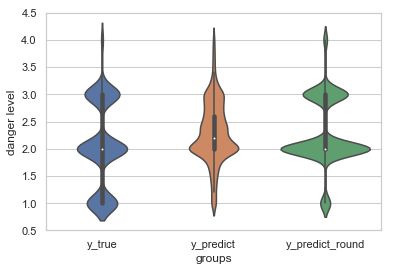

In [82]:
import seaborn as sns
sns.set(style="whitegrid")

fig, axes = plt.subplots()
sns.violinplot(x='groups',y='danger level', data=df_violin, ax = axes)


# not so good of a prediction :/ 
my model is not able to yield predictions of low danger levels

In [83]:
import pickle

In [ ]:
# save the model to disk
filename = 'avy_danger_prediction.pkl'
pickle.dump(pipe2, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

In [ ]:
X_test.head(10)
